# Recitation Course on FEM

# Finite Element Method

In [1]:
# Import packages
import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt

# Create mesh, using GMSH

http://linuxg.net/how-to-install-gmsh-2-8-5-on-the-most-popular-linux-systems/
http://gmsh.info 

Why mesh like that? 
Delaunay triangulation for a given set of discrete points in a plane is a triangulation such that no point is inside the circumcircle of any triangle. Delaunay triangulations maximize the minimum angle of all the angles of the triangles in the triangulation (more https://en.wikipedia.org/wiki/Delaunay_triangulation)

In [2]:
# Load preprocessed .txt files with geometry

# coordinates of all nodes
p = np.loadtxt('nodes_2ref.txt')
# unique triangles defined as the combination of 3 nodes 
t = np.loadtxt('triangles_2ref.txt')

# print
print(p)
print(t)

[[  1.           0.           0.           0.        ]
 [  2.           1.           0.           0.        ]
 [  3.           0.           1.           0.        ]
 ...
 [527.           0.79227974   0.90715345   0.        ]
 [528.           0.81075793   0.8623451    0.        ]
 [529.           0.9454054    0.77009422   0.        ]]
[[  1.   2.   2. ...  87. 184. 185.]
 [  2.   2.   2. ... 184.  26. 185.]
 [  3.   2.   2. ... 184.  25.  26.]
 ...
 [974.   2.   2. ... 506. 519. 529.]
 [975.   2.   2. ... 506. 181. 519.]
 [976.   2.   2. ... 529. 519. 167.]]


Text(0.5, 1.0, 'triplot of Delaunay triangulation')

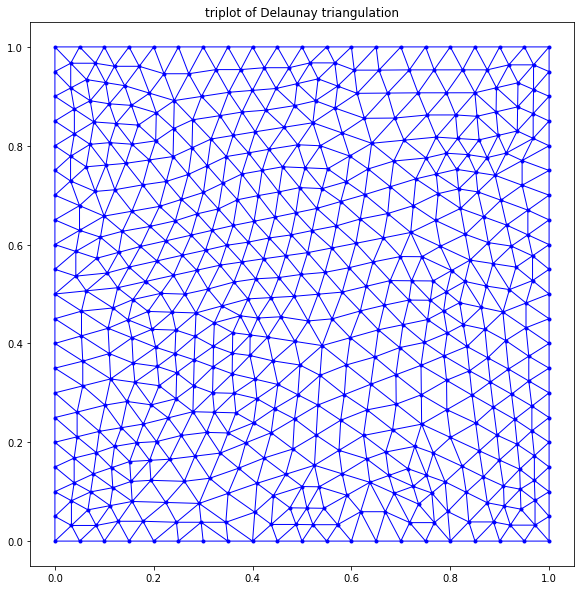

In [3]:
triang = tri.Triangulation(p[:,1], p[:,2], t[:,5:]-1)


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1, markersize=3)
ax1.set_title('triplot of Delaunay triangulation')

In [4]:
# Some more post-processing 

# since we are modeling the 2D case
p = np.delete(p, 3, 1) # delete fourth column of p
p = np.delete(p, 0, 1)

# deleted collumns are gmsh attributes related with the orientation of the surface that are not relevant in this case
t = np.delete(t, 0, 1)  # delete second column of t
t = np.delete(t, 0, 1)  # delete second column of t
t = np.delete(t, 0, 1)  # delete second column of t
t = np.delete(t, 0, 1)  # delete second column of t
t = np.delete(t, 0, 1)  # delete second column of t
t -= 1
print(p)
print(t)


[[0.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 ...
 [0.79227974 0.90715345]
 [0.81075793 0.8623451 ]
 [0.9454054  0.77009422]]
[[ 86. 183. 184.]
 [183.  25. 184.]
 [183.  24.  25.]
 ...
 [505. 518. 528.]
 [505. 180. 518.]
 [528. 518. 166.]]


Also, we will build simplest mesh. it will be rectangular triangles mesh.

<img src="fig/rectangular_grid.jpg">

In [5]:
N = 23
rec_x, rec_y = np.meshgrid(np.linspace(0,1,N), np.linspace(0,1,N))
rec_x_f = rec_x.flatten(order='C')
rec_y_f = rec_y.flatten(order='C')
rec_grid_p = np.array((rec_x_f, rec_y_f))

In [6]:
rec_grid_t = np.array([[],[],[]])
for i in range (0,N**2):
    if (i+1)%N!=0 and (i+N)<N**2: # for upper triangles
        rec_grid_t = np.append(rec_grid_t, np.array([[i],[i+1],[i+N]]), axis=1)
    if (i+1)%N!=0 and (i+N+1)<N**2: # for lower triangles
        rec_grid_t = np.append(rec_grid_t, np.array([[i+1],[i+N],[i+N+1]]), axis=1)

In [7]:
rec_grid_p = np.swapaxes(rec_grid_p,0,1)
rec_grid_t = np.swapaxes(rec_grid_t,0,1)

### Assembling the matrix

Classical way:

* Notice that $\nabla v_k$ are piecewise constant:
$$
A_{k,\ell}
= \int_{\Omega} \nabla v_k \cdot \nabla v_\ell
= \sum_{T\in\mathcal T} |T| (\nabla v_k|_T) \cdot (\nabla v_\ell|_T),
$$
where $|T|$ is the volume or area of $T$

* Pseudocode:
```
for k = 1 to n
  for l = 1 to n
    for all T
      if(k and l are nodes of T)
      // otherwise the integral is zero
        A(k,l) += |T|
           *(\nabla v_k|_T)
           *(\nabla v_l|_T)
```

* The loops in the algorithm are often reversed:
```
for all T
    for k, vertices of T
        for l, vertices of T
            A(k,l) += <<as before>>
```


* We have
$$
2 |T| = \det \left(
\begin{array}{cc}
x _2 - x _1 & y _2 - y _1 \\
x _3 - x _1 & y _3 - y _1 \\
\end{array}
\right)
$$
Let $T$'s nodes being $n_1$, $n_2$, $n_3$. Denote $\eta_i := v_{n_i}$.
Then it can be shown
$$
\nabla \eta _j = \frac{1}{2|T|}
\left(
\begin{array}{cc}
y _{j+1} - y _{j+2} \\
x _{j+2} - x _{j+1} \\
\end{array}
\right)
$$
Here we mean $(x_4,y_4) = (x_1,y_1)$, $(x_5,y_5) = (x_2,y_2)$


* Let's denote the matrix $M_{j,k} = |T| (\nabla \eta_j)\cdot(\nabla \eta_k)$. It can be evaluated as
$$
M = \frac{|T|}{2} G G^T
\qquad\text{where}\qquad
G =
\left(
\begin{array}{ccc}
1 & 1 & 1 \\
x _1 & x _2 & x _3 \\
y _1 & y _2 & y _3
\end{array}
\right)^{-1}
\left(
\begin{array}{ccc}
0 & 0 \\
1 & 0 \\
0 & 1
\end{array}
\right)
$$

* Pseudocode:
```
for all T
    calculate M
    for k=1..3
        for l=1..3
            A(nodes(k),nodes(l)) += M(k,l)
```


### Assembling the right-hand side (forces)

$$
\int_T f \eta_i \approx f(x_S, y_S) \int_\Omega \eta_i,
$$
where $(x_S,y_S)$ is the center of mass of the triangle. 

* Pseudocode:
```
for all T
  calculate f(xS, yS)
  for k=1..3
    f(nodes(k)) += 1/3 * area(T) * f(xS, yS)
```

### How about boundary conditions?

* pseudocode:
```
A = zero matrix for free nodes
for k = free nodes
    for l = free nodes
        for all T
            <<SAME>>
```
This fills only the needed rows & columns of the matrix, but for convenience the loops in the algorithm are often reversed:

* pseudocode
```
A = zero matrix for all nodes
for all T
    <<SAME>>
remove rows and columns from A corr. to non-free nodes
```

* The **free nodes** are those that are on $\Gamma_2$ in
$$
\begin{align*}
-\Delta u &= 0\qquad\text{on $\Omega$}
\\
u &= 0\qquad\text{on $\Gamma_1$}
\\
u_n &= 0\qquad\text{on $\Gamma_2$}
\end{align*}
$$

* Alternatively, one can **replace** the corresponding row and column by
$$
\begin{pmatrix}
\cdot & 0 & \cdot & \cdot \\
0 & 1 & 0 & 0\\
\cdot & 0 & \cdot & \cdot \\
\cdot & 0 & \cdot & \cdot \\
\end{pmatrix}
$$

In [8]:
# Get the number of nodes and triangles
N = len(p)
T = len(t)

print(np.shape(p))
print(np.shape(t))

# Also for rectangular triangles grid

rec_N = rec_grid_p.shape[0]
rec_T = rec_grid_t.shape[0]

print(np.shape(rec_grid_p))
print(np.shape(rec_grid_t))

(529, 2)
(976, 3)
(529, 2)
(968, 3)


In [9]:
def Solver(p,t,N,T):
    # Solve the simplest problem -Du = 1, Dirichlet boundary conditions

    A = np.zeros((N,N))
    b = np.zeros(N)

    # One big loop for all triangles
    for i in range(0,T):

        # Extract the vertices of the triangles
        p1 = p[int(t[i,0]),:2] #x1,y1
        p2 = p[int(t[i,1]),:2] #x2,y2
        p3 = p[int(t[i,2]),:2] #x3,y3

        # Put vertices into one array
        verts = np.stack((p1, p2, p3))

        # Find the area of the triangle
        T_area = np.abs(np.linalg.det([[p2[0]-p1[0],p2[1]-p1[1]],[p3[0]-p1[0],p3[1]-p1[1]]])/2)

        # Loop for the nodes
        for k in range(0,3):
            for j in range(0,3):

                # Index
                k1 = (k+1)%3
                k2 = (k+2)%3
                j1 = (j+1)%3
                j2 = (j+2)%3

                # Gradients(nabla)
                grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
                grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])

                # Fill the matrix
                A[int(t[i,j]),int(t[i,k])] += 1./(4*T_area)*np.dot(grad1,grad2) 

            # Right hand side
            b[int(t[i,k])] += 1/3*T_area*1;


    # Boundary Conditions
    for n in range(0,N):
        if p[n,0] == 0.0 or p[n,1] == 0.0 or p[n,0] == 1.0 or p[n,1] == 1.0:
            A[n,:] = 0
            A[:,n] = 0
            A[n,n] = 1
            b[n] = 0

    sol = np.linalg.solve(A, b)
    return sol, A

In [10]:
sol, A = Solver(p, t, N, T)
rec_sol, rec_A  = Solver(rec_grid_p, rec_grid_t, rec_N, rec_T)

In [11]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm

In [12]:
def plot_img(p, sol):
    p1_new, p2_new, sol_new = zip(*sorted(zip(p[:,0], p[:,1], sol)))
    grid_x, grid_y = np.meshgrid(np.linspace(0,1,1000), np.linspace(0,1,1000))

    Interp_sol = griddata((p[:,0], p[:,1]), sol, (grid_x, grid_y), method='cubic')

    fig, ax = plt.subplots(1,2, figsize=(10,10))

    im1 = ax[0].imshow(Interp_sol, cmap=cm.coolwarm, vmin=abs(sol).min(), vmax=abs(sol).max())
    im2 = ax[1].imshow(Interp_sol, cmap=cm.Accent, vmin=abs(sol).min(), vmax=abs(sol).max())

    cb = fig.colorbar(im2, ax=ax)
    cb = fig.colorbar(im1, ax=ax)

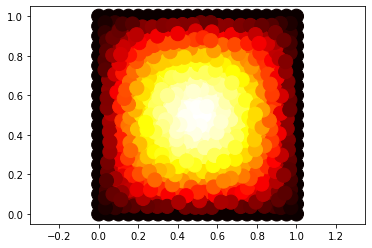

In [13]:
plt.scatter(p[:,0], p[:,1], c=sol,s=200)
plt.axis('equal')
plt.hot()

plt.show()

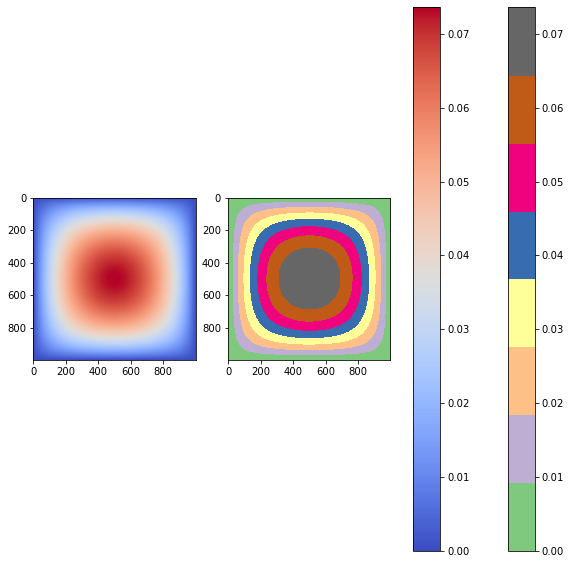

In [14]:
plot_img(p,sol)

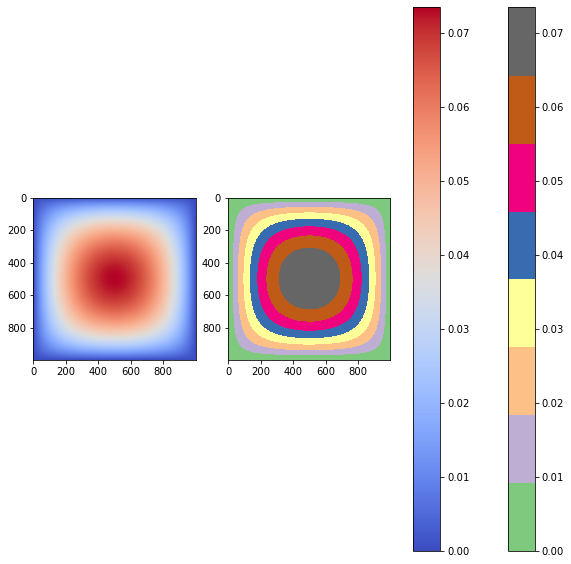

In [15]:
plot_img(rec_grid_p,rec_sol)

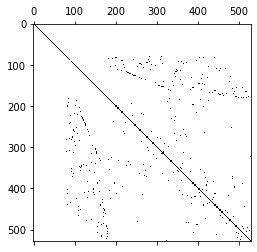

In [16]:
plt.spy(A)
plt.show()